# ⚡️ Energy-Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent ['Deep Energy-Based Generative Models' tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) created by Phillip Lippe.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

In [ ]:
#retreive elements from the datasets
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [ ]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [ ]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0) #add padding of -1 around each value in the img matrix
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

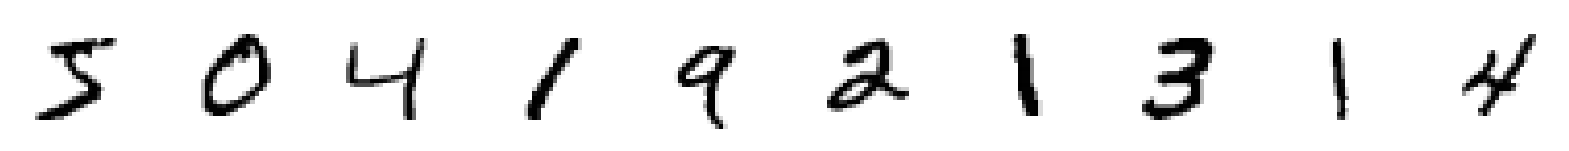

In [ ]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

In [ ]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(16, kernel_size=5, strides=2, padding="same", activation=activations.swish)(ebm_input)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation=activations.swish)(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation=activations.swish)(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation=activations.swish)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [ ]:
if LOAD_MODEL:
    model.load_weights("./models/model.h5")

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [ ]:
# Function to generate samples using Langevin Dynamics
def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [ ]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1 for _ in range(BATCH_SIZE)]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1)
        old_imgs = tf.concat(random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0)
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise)
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [ ]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean=0, stddev=NOISE)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(steps=STEPS, step_size=STEP_SIZE, noise=NOISE)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)
            reg_loss = self.alpha * tf.reduce_mean(real_out**2 + fake_out**2, axis=0)
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))* 2 - 1)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [ ]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [ ]:
# Compile and train the model
ebm.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True)

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (np.random.uniform(size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1)
        generated_images = generate_samples(ebm.model, start_imgs, steps=1000, step_size=STEP_SIZE, noise=NOISE, return_img_per_step=False)
        generated_images = generated_images.numpy()
        display( generated_images, save_to="./generated_img_%03d.png" % (epoch))

        example_images = tf.concat(random.choices(ebm.buffer.examples, k=10), axis=0)
        example_images = example_images.numpy()
        display(example_images, save_to="./example_img_%03d.png" % (epoch))


image_generator_callback = ImageGenerator(num_img=10)

In [ ]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights(".model.h5")


save_model_callback = SaveModel()

Epoch 1/60


469/469 [==============================] - ETA: 0s - loss: -0.0421 - reg: 0.0173 - cdiv: -0.0594 - real: 0.2570 - fake: 0.1975
Saved to ./generated_img_000.png


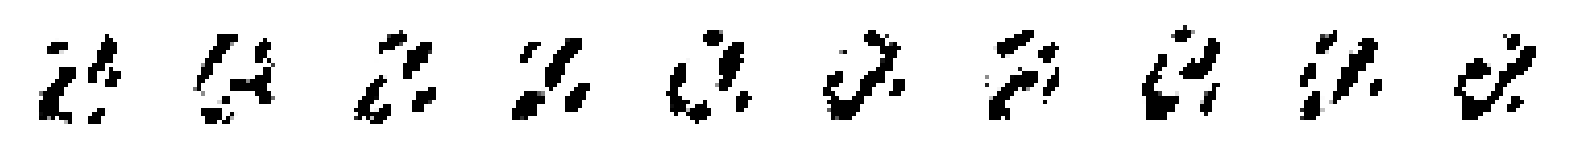


Saved to ./example_img_000.png


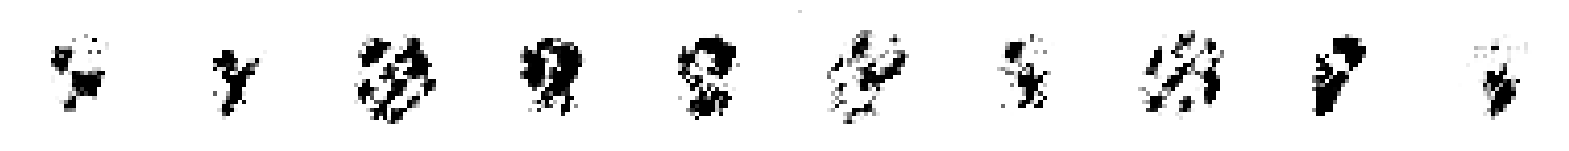

469/469 [==============================] - 579s 1s/step - loss: -0.0421 - reg: 0.0173 - cdiv: -0.0594 - real: 0.2570 - fake: 0.1975 - val_cdiv: -1.4038 - val_real: 0.0188 - val_fake: -1.3851
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -0.0069 - reg: 0.0035 - cdiv: -0.0104 - real: 0.0199 - fake: 0.0095
Saved to ./generated_img_001.png


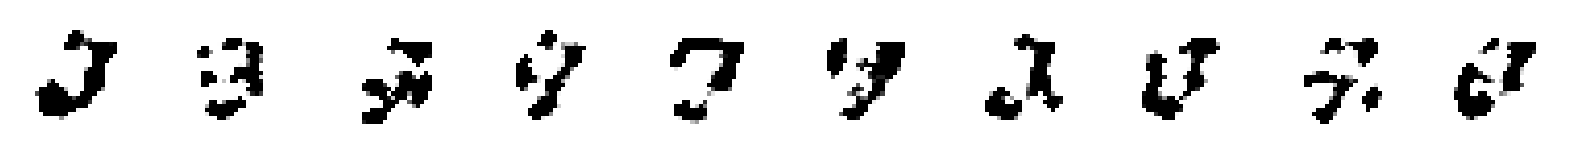


Saved to ./example_img_001.png


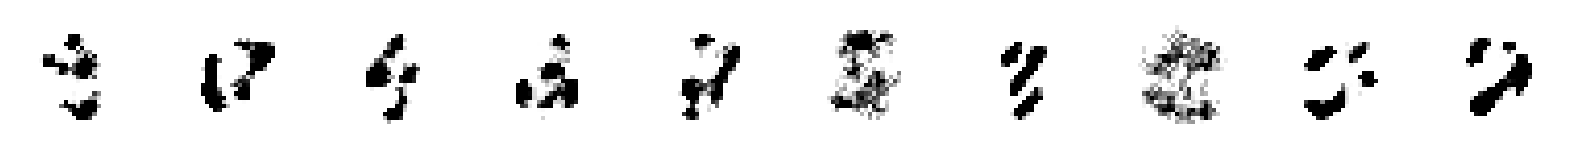

469/469 [==============================] - 651s 1s/step - loss: -0.0069 - reg: 0.0035 - cdiv: -0.0104 - real: 0.0199 - fake: 0.0095 - val_cdiv: -1.7655 - val_real: -0.0905 - val_fake: -1.8560
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: -0.0025 - reg: 0.0015 - cdiv: -0.0040 - real: 0.0063 - fake: 0.0023
Saved to ./generated_img_002.png


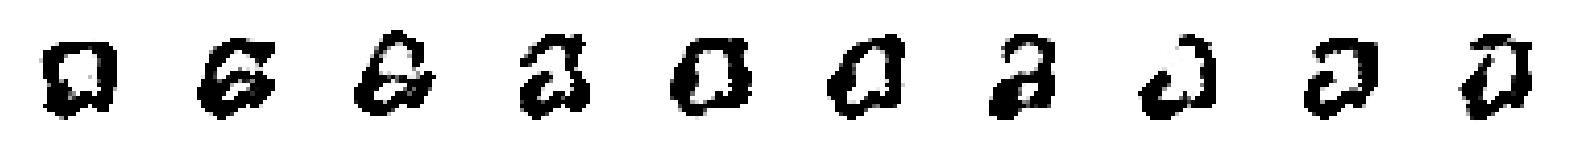


Saved to ./example_img_002.png


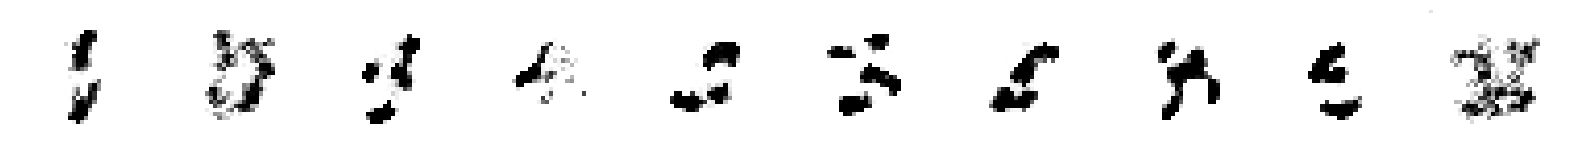

469/469 [==============================] - 601s 1s/step - loss: -0.0025 - reg: 0.0015 - cdiv: -0.0040 - real: 0.0063 - fake: 0.0023 - val_cdiv: -2.1588 - val_real: -0.0430 - val_fake: -2.2018
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: 2.2126e-04 - reg: 5.8687e-04 - cdiv: -3.6560e-04 - real: 0.0019 - fake: 0.0015
Saved to ./generated_img_003.png


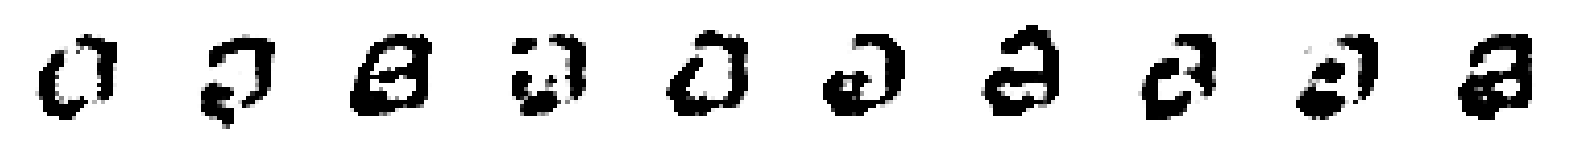


Saved to ./example_img_003.png


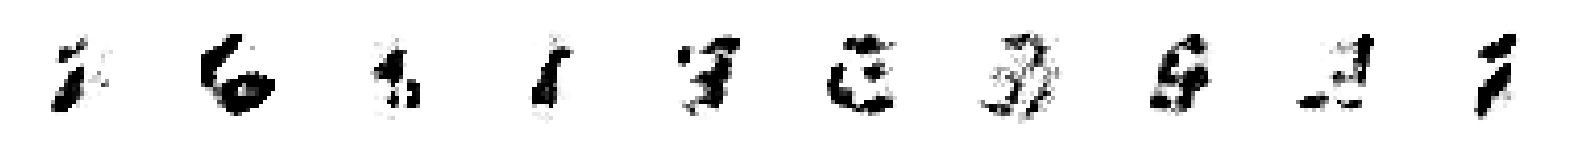

469/469 [==============================] - 592s 1s/step - loss: 2.2126e-04 - reg: 5.8687e-04 - cdiv: -3.6560e-04 - real: 0.0019 - fake: 0.0015 - val_cdiv: -2.4201 - val_real: -0.0164 - val_fake: -2.4365
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: 8.4256e-04 - reg: 3.1302e-04 - cdiv: 5.2953e-04 - real: 6.0793e-04 - fake: 0.0011
Saved to ./generated_img_004.png


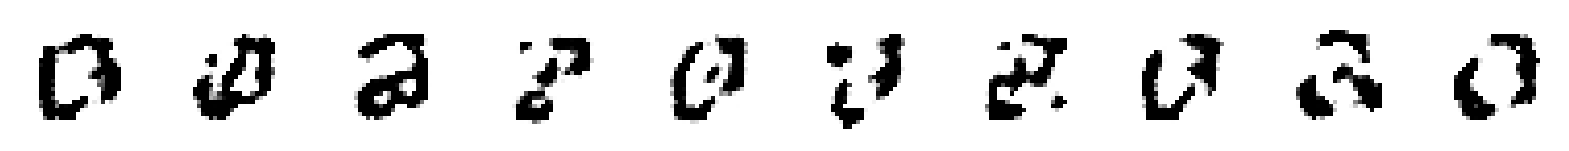


Saved to ./example_img_004.png


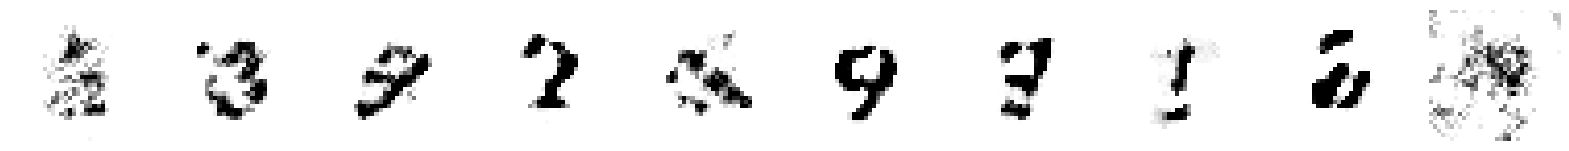

469/469 [==============================] - 560s 1s/step - loss: 8.4256e-04 - reg: 3.1302e-04 - cdiv: 5.2953e-04 - real: 6.0793e-04 - fake: 0.0011 - val_cdiv: -2.5850 - val_real: -0.0135 - val_fake: -2.5984
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: 3.9036e-04 - reg: 2.6315e-04 - cdiv: 1.2721e-04 - real: 4.5695e-04 - fake: 5.8416e-04
Saved to ./generated_img_005.png


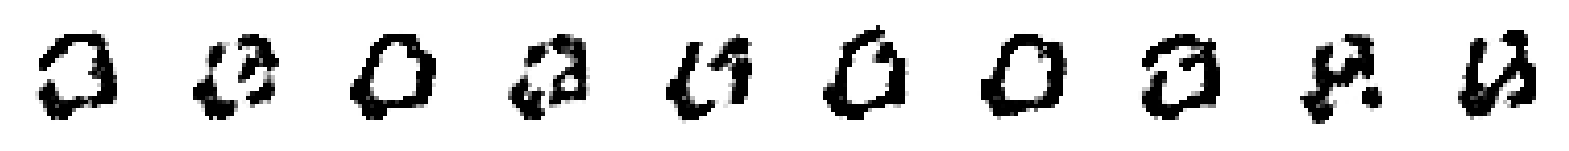


Saved to ./example_img_005.png


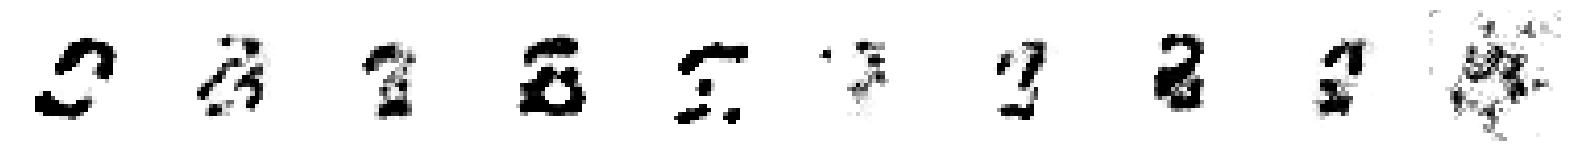

469/469 [==============================] - 552s 1s/step - loss: 3.9036e-04 - reg: 2.6315e-04 - cdiv: 1.2721e-04 - real: 4.5695e-04 - fake: 5.8416e-04 - val_cdiv: -2.8748 - val_real: 0.0097 - val_fake: -2.8651
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: 2.4432e-04 - reg: 3.1574e-04 - cdiv: -7.1414e-05 - real: 0.0011 - fake: 9.9508e-04
Saved to ./generated_img_006.png


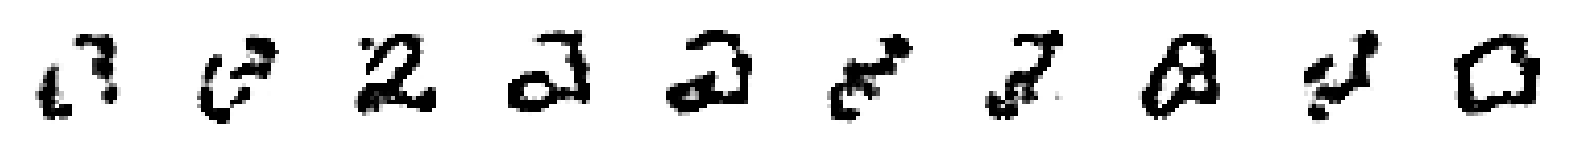


Saved to ./example_img_006.png


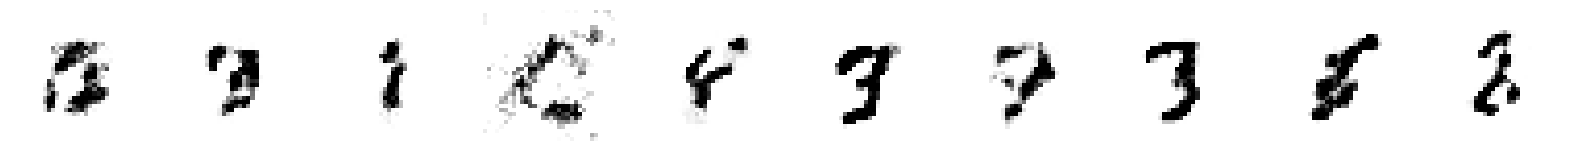

469/469 [==============================] - 551s 1s/step - loss: 2.4432e-04 - reg: 3.1574e-04 - cdiv: -7.1414e-05 - real: 0.0011 - fake: 9.9508e-04 - val_cdiv: -3.2543 - val_real: 6.2416e-04 - val_fake: -3.2537
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: 4.6539e-04 - reg: 2.7120e-04 - cdiv: 1.9420e-04 - real: 5.1612e-05 - fake: 2.4581e-04
Saved to ./generated_img_007.png


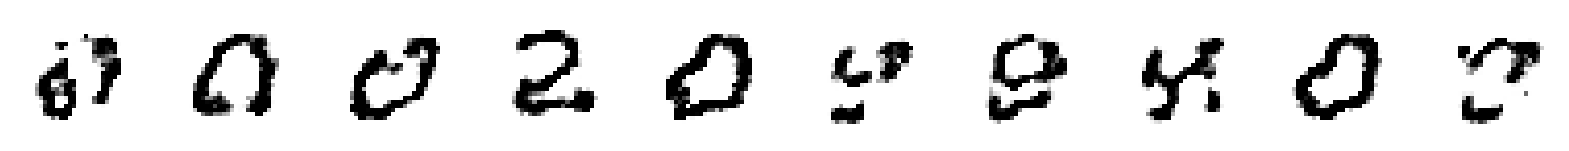


Saved to ./example_img_007.png


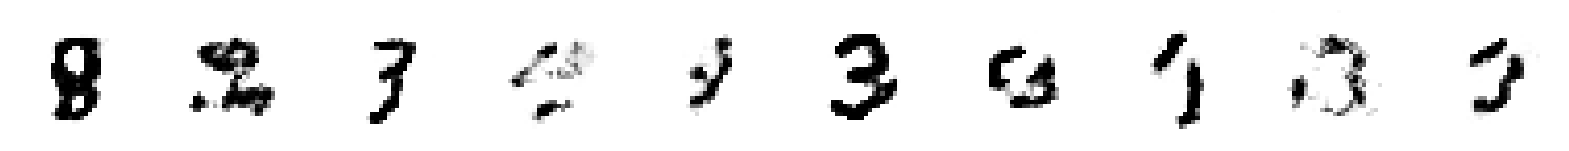

469/469 [==============================] - 550s 1s/step - loss: 4.6539e-04 - reg: 2.7120e-04 - cdiv: 1.9420e-04 - real: 5.1612e-05 - fake: 2.4581e-04 - val_cdiv: -3.5201 - val_real: 0.0062 - val_fake: -3.5139
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: 4.2952e-05 - reg: 3.1448e-04 - cdiv: -2.7153e-04 - real: 7.7048e-04 - fake: 4.9896e-04
Saved to ./generated_img_008.png


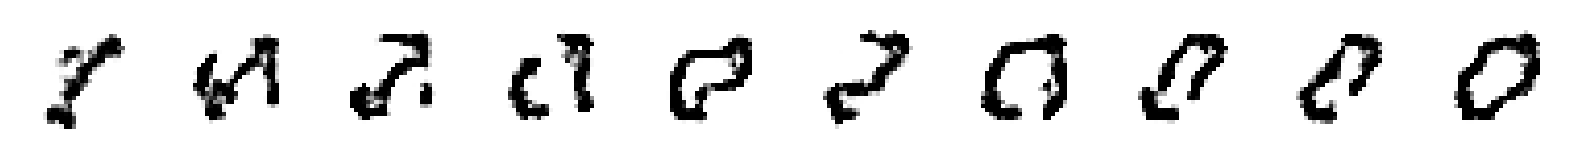


Saved to ./example_img_008.png


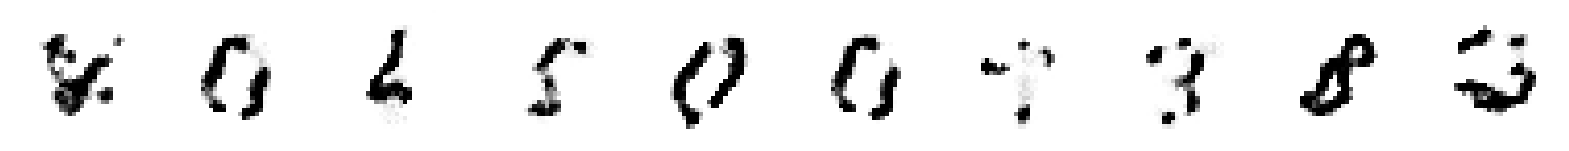

469/469 [==============================] - 552s 1s/step - loss: 4.2952e-05 - reg: 3.1448e-04 - cdiv: -2.7153e-04 - real: 7.7048e-04 - fake: 4.9896e-04 - val_cdiv: -3.8449 - val_real: 0.0128 - val_fake: -3.8321
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: -9.3433e-05 - reg: 3.4611e-04 - cdiv: -4.3954e-04 - real: 0.0010 - fake: 5.9873e-04    
Saved to ./generated_img_009.png


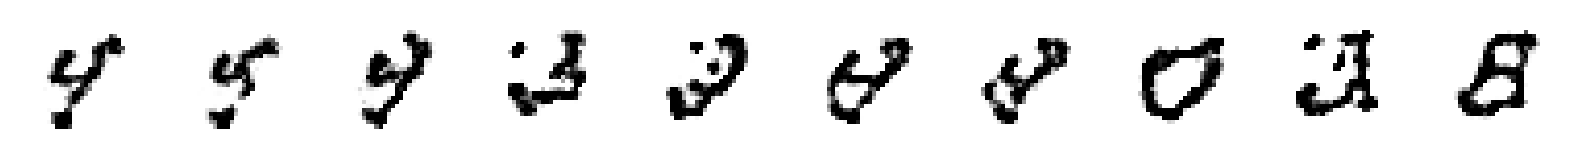


Saved to ./example_img_009.png


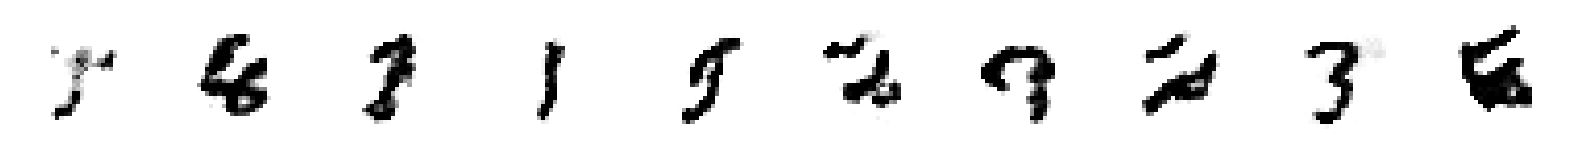

469/469 [==============================] - 551s 1s/step - loss: -9.3433e-05 - reg: 3.4611e-04 - cdiv: -4.3954e-04 - real: 0.0010 - fake: 5.9873e-04 - val_cdiv: -4.2829 - val_real: 0.0165 - val_fake: -4.2664
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: 1.5246e-04 - reg: 3.2422e-04 - cdiv: -1.7176e-04 - real: 1.7253e-04 - fake: 7.6955e-07 
Saved to ./generated_img_010.png


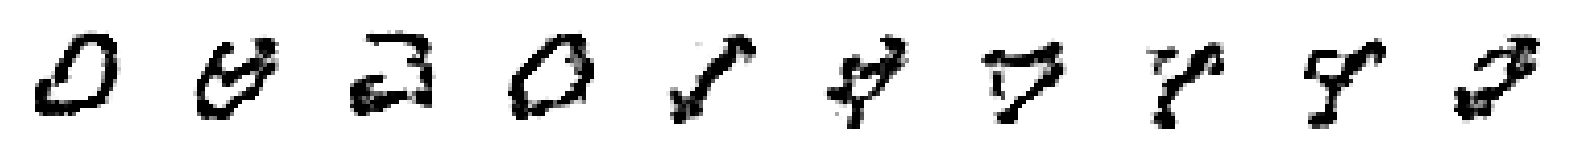


Saved to ./example_img_010.png


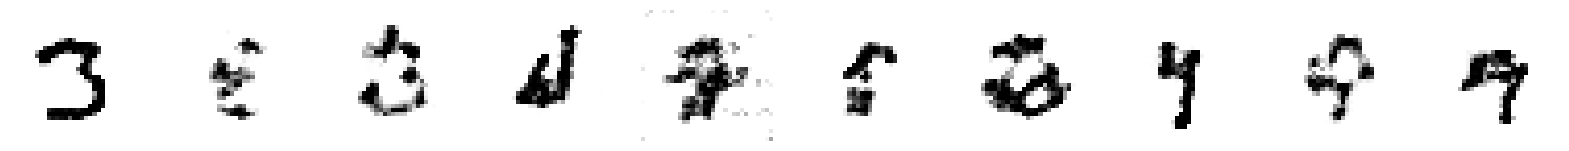

469/469 [==============================] - 586s 1s/step - loss: 1.5246e-04 - reg: 3.2422e-04 - cdiv: -1.7176e-04 - real: 1.7253e-04 - fake: 7.6955e-07 - val_cdiv: -4.6045 - val_real: 0.0261 - val_fake: -4.5784
Epoch 12/60
469/469 [==============================] - ETA: 0s - loss: -9.0100e-05 - reg: 3.1290e-04 - cdiv: -4.0300e-04 - real: 7.6448e-04 - fake: 3.6149e-04
Saved to ./generated_img_011.png


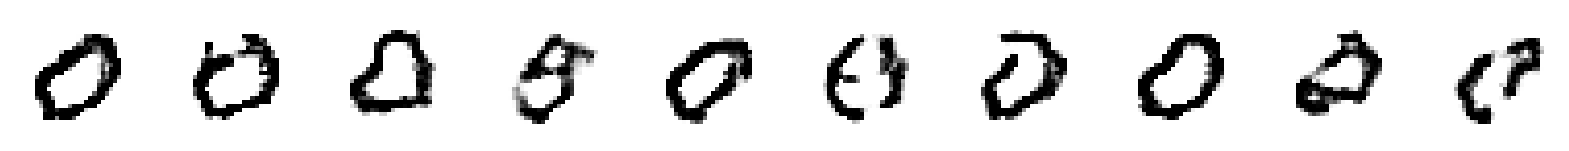


Saved to ./example_img_011.png


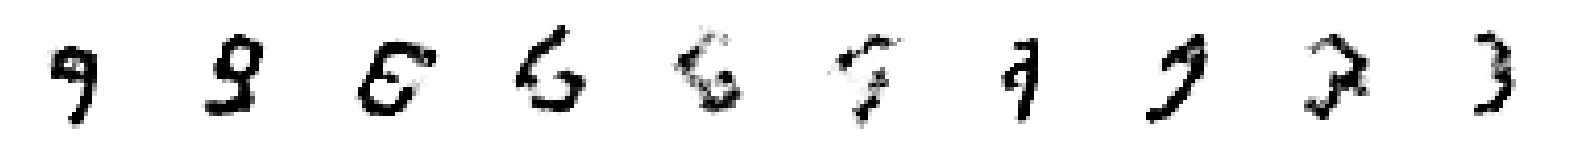

469/469 [==============================] - 619s 1s/step - loss: -9.0100e-05 - reg: 3.1290e-04 - cdiv: -4.0300e-04 - real: 7.6448e-04 - fake: 3.6149e-04 - val_cdiv: -5.0199 - val_real: 0.0279 - val_fake: -4.9919
Epoch 13/60
469/469 [==============================] - ETA: 0s - loss: 4.2906e-04 - reg: 3.3666e-04 - cdiv: 9.2397e-05 - real: 1.1242e-04 - fake: 2.0481e-04
Saved to ./generated_img_012.png


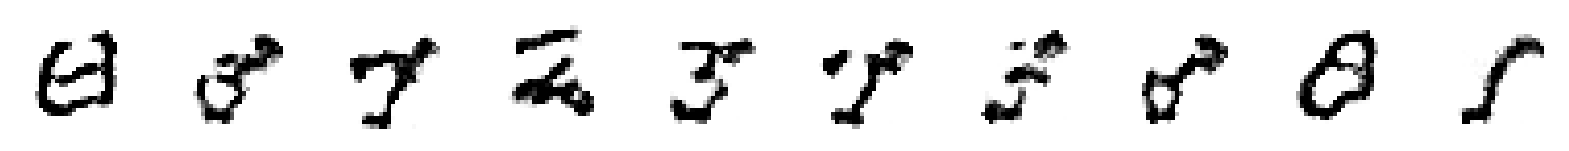


Saved to ./example_img_012.png


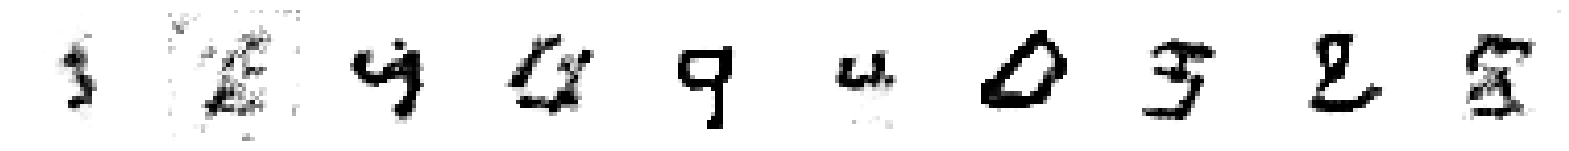

469/469 [==============================] - 593s 1s/step - loss: 4.2906e-04 - reg: 3.3666e-04 - cdiv: 9.2397e-05 - real: 1.1242e-04 - fake: 2.0481e-04 - val_cdiv: -5.1994 - val_real: 0.0304 - val_fake: -5.1691
Epoch 14/60
469/469 [==============================] - ETA: 0s - loss: 8.3857e-05 - reg: 2.4309e-04 - cdiv: -1.5924e-04 - real: 1.5595e-04 - fake: -3.2926e-06
Saved to ./generated_img_013.png


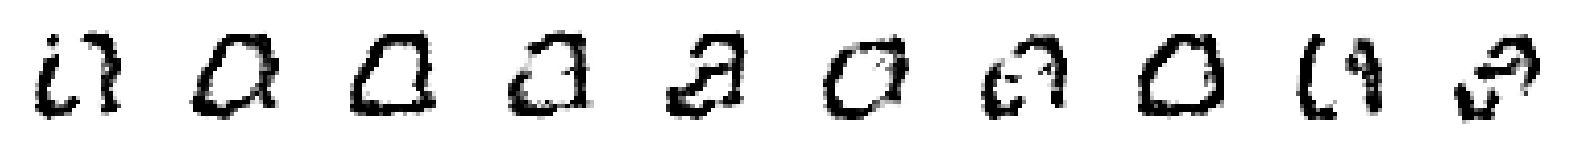


Saved to ./example_img_013.png


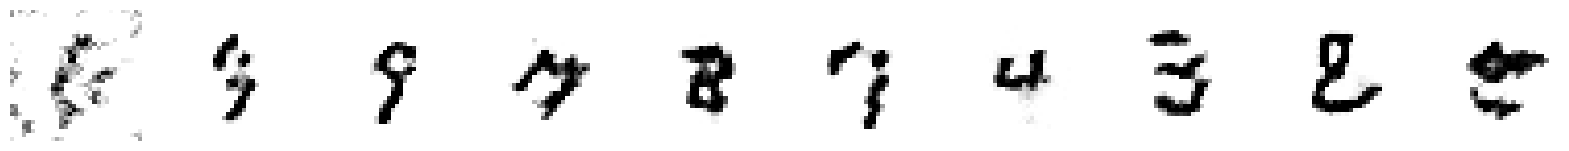

469/469 [==============================] - 596s 1s/step - loss: 8.3857e-05 - reg: 2.4309e-04 - cdiv: -1.5924e-04 - real: 1.5595e-04 - fake: -3.2926e-06 - val_cdiv: -5.5612 - val_real: 0.0575 - val_fake: -5.5037
Epoch 15/60
469/469 [==============================] - ETA: 0s - loss: -2.8194e-05 - reg: 2.3918e-04 - cdiv: -2.6737e-04 - real: 4.9553e-04 - fake: 2.2816e-04
Saved to ./generated_img_014.png


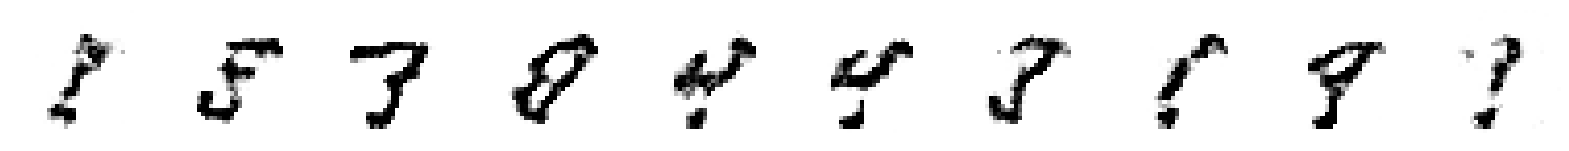


Saved to ./example_img_014.png


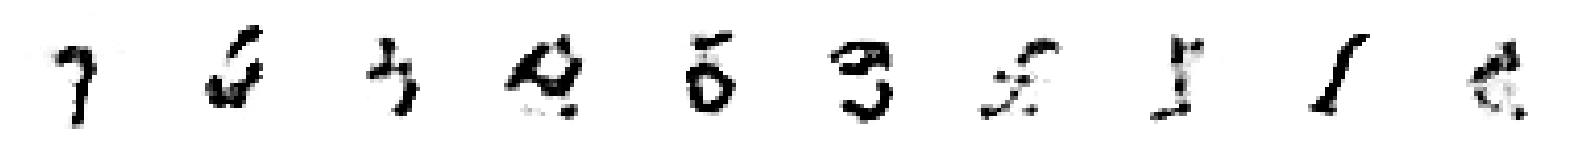

469/469 [==============================] - 602s 1s/step - loss: -2.8194e-05 - reg: 2.3918e-04 - cdiv: -2.6737e-04 - real: 4.9553e-04 - fake: 2.2816e-04 - val_cdiv: -5.8359 - val_real: 0.0321 - val_fake: -5.8038
Epoch 16/60
469/469 [==============================] - ETA: 0s - loss: 3.8102e-04 - reg: 2.2447e-04 - cdiv: 1.5655e-04 - real: 1.6966e-04 - fake: 3.2620e-04
Saved to ./generated_img_015.png


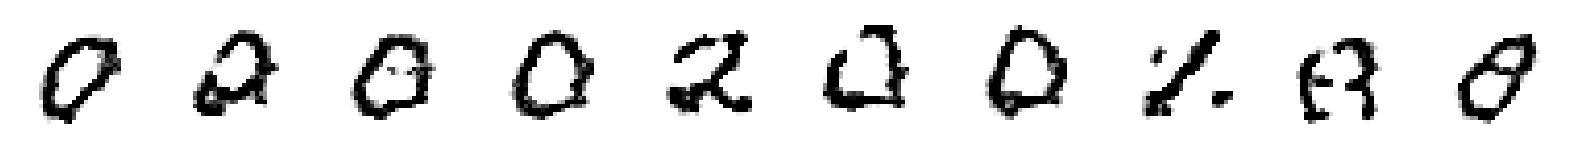


Saved to ./example_img_015.png


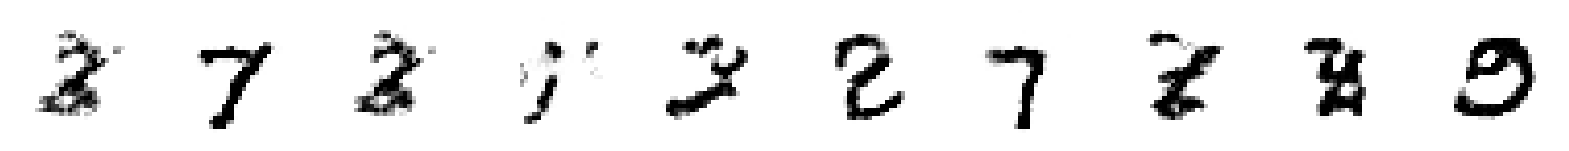

469/469 [==============================] - 588s 1s/step - loss: 3.8102e-04 - reg: 2.2447e-04 - cdiv: 1.5655e-04 - real: 1.6966e-04 - fake: 3.2620e-04 - val_cdiv: -5.9196 - val_real: 0.0213 - val_fake: -5.8983
Epoch 17/60
469/469 [==============================] - ETA: 0s - loss: 2.0930e-04 - reg: 2.2277e-04 - cdiv: -1.3465e-05 - real: 2.8220e-04 - fake: 2.6874e-04
Saved to ./generated_img_016.png


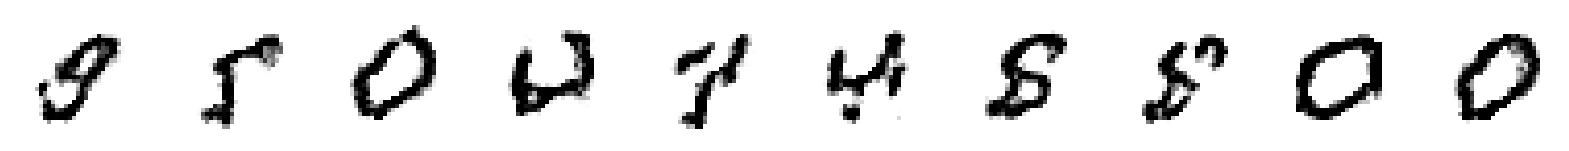


Saved to ./example_img_016.png


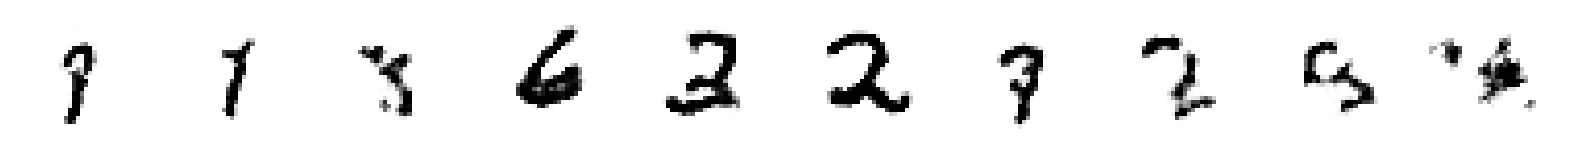

469/469 [==============================] - 552s 1s/step - loss: 2.0930e-04 - reg: 2.2277e-04 - cdiv: -1.3465e-05 - real: 2.8220e-04 - fake: 2.6874e-04 - val_cdiv: -6.2932 - val_real: 0.0344 - val_fake: -6.2588
Epoch 18/60
469/469 [==============================] - ETA: 0s - loss: -1.1939e-04 - reg: 2.2067e-04 - cdiv: -3.4006e-04 - real: 7.6848e-04 - fake: 4.2842e-04
Saved to ./generated_img_017.png


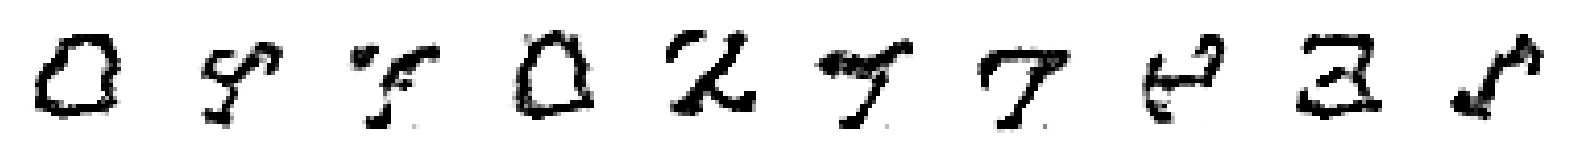


Saved to ./example_img_017.png


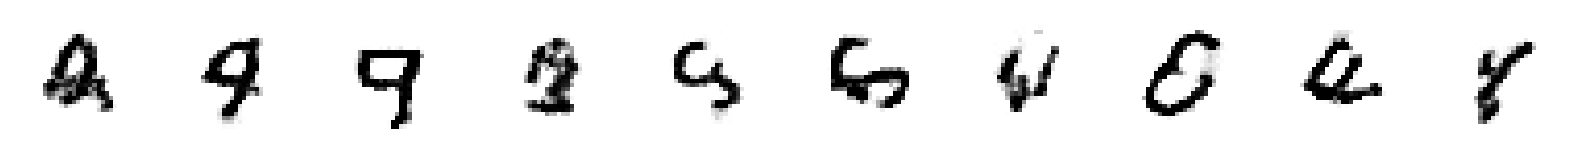

469/469 [==============================] - 555s 1s/step - loss: -1.1939e-04 - reg: 2.2067e-04 - cdiv: -3.4006e-04 - real: 7.6848e-04 - fake: 4.2842e-04 - val_cdiv: -6.6540 - val_real: 0.0253 - val_fake: -6.6288
Epoch 19/60
134/469 [=======>......................] - ETA: 6:22 - loss: 2.3405e-04 - reg: 3.9161e-04 - cdiv: -1.5756e-04 - real: -0.0014 - fake: -0.0016

In [ ]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Generate images <a name="generate"></a>

In [ ]:
start_imgs = (np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1)

In [ ]:
display(start_imgs)

In [ ]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

In [ ]:
display(gen_img[-1].numpy())

In [ ]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))